<a id='top'> </a>

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

last updated: 2017-07-26 

CPython 2.7.13
IPython 5.3.0

numpy 1.12.1
matplotlib 2.0.2
scipy 0.19.0
pandas 0.20.1
sklearn 0.18.1
mlxtend 0.6.0


# CR anisotropy random trials
### Table of contents
1. [Define analysis free parameters](#Define-analysis-free-parameters)
2. [Projected relative intensity](#Projected-relative-intensity)
3. [Cross-check: random splitting of events](#Cross-check:-random-splitting-of-events)

In [2]:
%matplotlib inline
from __future__ import division, print_function
from collections import defaultdict
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.gridspec as gridspec
import healpy as hp
import dask
from dask import delayed, multiprocessing
from dask.diagnostics import ProgressBar
import pyprind
from scipy.special import erfcinv

import comptools as comp
import comptools.analysis.plotting as plotting
import comptools.anisotropy.anisotropy as anisotropy
import comptools.anisotropy.teststatistic as ts

color_dict = comp.analysis.get_color_dict()

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [29]:
config = ['IC86.2011', 'IC86.2012', 'IC86.2013', 'IC86.2014', 'IC86.2015']
years_str = '2011-2015'
composition='all'

n_side = 64
scale = 3
smooth = 0.0
n_bins = 60
decmax = -55
low_energy = True

In [30]:
figures_dir = os.path.join(comp.paths.figures_dir, 'anisotropy', 'random-trials',
                           'smooth-{}_RAbins-{}_decmax-{}'.format(int(smooth), int(n_bins), int(decmax)))
if not os.path.isdir(figures_dir):
    print('Making the directory {}'.format(figures_dir))
    os.makedirs(figures_dir)

Making the directory /home/jbourbeau/public_html/figures/composition/anisotropy/random-trials/smooth-0_RAbins-60_decmax--55


In [31]:
n_total = anisotropy.get_num_events(config=config, composition='all', decmax=decmax, low_energy=low_energy)
n_light = anisotropy.get_num_events(config=config, composition='light', decmax=decmax, low_energy=low_energy)
n_heavy = anisotropy.get_num_events(config=config, composition='heavy', decmax=decmax, low_energy=low_energy)

In [32]:
n_light/n_total, n_heavy/n_total

(0.61957196958179239, 0.38042788194747984)

## Relative intensity sky maps for light, heavy, and all compositions

In [33]:
kwargs_relint = {'config': config, 'low_energy': low_energy, 'smooth': smooth, 'scale': scale, 'decmax': decmax}

In [34]:
relint_all = anisotropy.get_map(name='relint', composition='all', **kwargs_relint)
relint_light = anisotropy.get_map(name='relint', composition='light', **kwargs_relint)
relint_heavy = anisotropy.get_map(name='relint', composition='heavy', **kwargs_relint)

In [35]:
kwargs_plot_relint = {'smooth': smooth, 'scale': scale, 'decmax': decmax}

877.550983866
-487.17949972


/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/healpy/projector.py:750: RuntimeWarning: invalid value encountered in greater
  mask = (np.asarray(x)**2+np.asarray(y)**2>1.0)
/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/healpy/projaxes.py:387: RuntimeWarning: invalid value encountered in greater
  w=np.where(d2 > threshold)[0]


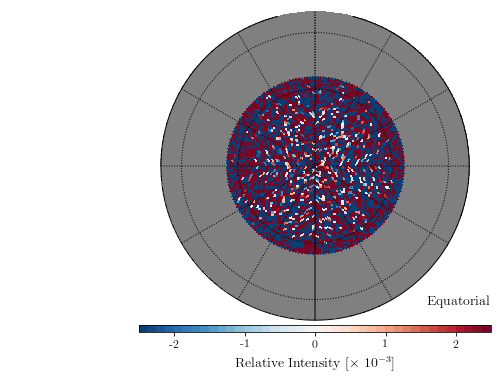

In [36]:
print(relint_all.max())
print(relint_all[relint_all != hp.UNSEEN].min())
title = 'Relative Intensity [$\\times \ 10^{}$]'.format('{'+str(-scale)+'}')
fig, ax = anisotropy.plot_skymap(relint_all, color_palette='RdBu_r', symmetric=True, llabel=years_str, 
                                 cbar_title=title, cbar_min=-2.5, cbar_max=2.5, polar=True, **kwargs_plot_relint)
outfile = 'IC86-{}_relint_{}_nside-{}_smooth-{:0.1f}_decmax-{}.png'.format(years_str, 'all', n_side, smooth, decmax)
plt.savefig(os.path.join(figures_dir, outfile))

1285.71424679
-775.280904294


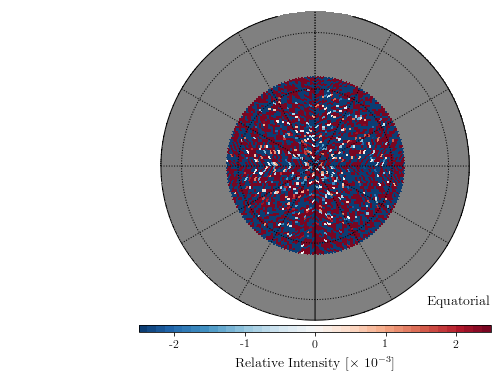

In [11]:
print(relint_light.max())
print(relint_light[relint_light != hp.UNSEEN].min())
title = 'Relative Intensity [$\\times \ 10^{}$]'.format('{'+str(-scale)+'}')
fig, ax = anisotropy.plot_skymap(relint_light, color_palette='RdBu_r', symmetric=True, llabel=years_str, 
                                 cbar_title=title, cbar_min=-2.5, cbar_max=2.5, polar=True, **kwargs_plot_relint)
outfile = 'IC86-{}_relint_{}_nside-{}_smooth-{:0.1f}_decmax-{}.png'.format(years_str, 'light', n_side, smooth, decmax)
plt.savefig(os.path.join(figures_dir, outfile))

1312.13870283
-632.352951489


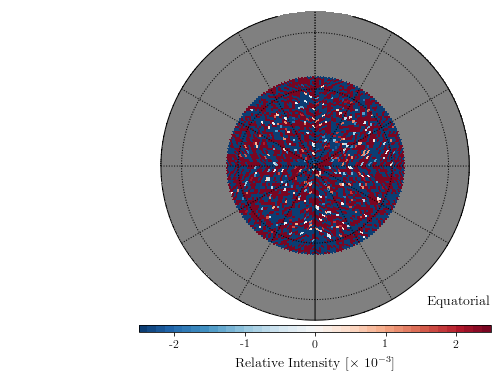

In [12]:
print(relint_heavy.max())
print(relint_heavy[relint_heavy != hp.UNSEEN].min())
title = 'Relative Intensity [$\\times \ 10^{}$]'.format('{'+str(-scale)+'}')
fig, ax = anisotropy.plot_skymap(relint_heavy, color_palette='RdBu_r', symmetric=True, llabel=years_str, 
                                 cbar_title=title, cbar_min=-2.5, cbar_max=2.5, polar=True, **kwargs_plot_relint)
outfile = 'IC86-{}_relint_{}_nside-{}_smooth-{:0.1f}_decmax-{}.png'.format(years_str, 'heavy', n_side, smooth, decmax)
plt.savefig(os.path.join(figures_dir, outfile))

## Significance sky maps for light, heavy, and all compositions

In [13]:
kwargs_sig = {'config': config, 'low_energy': low_energy, 'smooth': smooth, 'scale': None, 'decmax': decmax}

In [14]:
sig_all = anisotropy.get_map(name='sig', composition='all', **kwargs_sig)
sig_light = anisotropy.get_map(name='sig', composition='light', **kwargs_sig)
sig_heavy = anisotropy.get_map(name='sig', composition='heavy', **kwargs_sig)

In [15]:
kwargs_plot_sig = {'smooth': smooth, 'scale': None, 'decmax': decmax}

3.9636389401
-3.90569320971


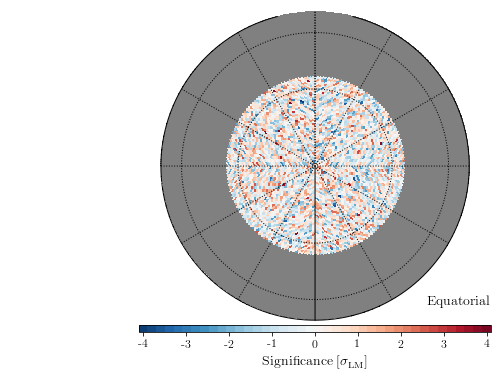

In [16]:
print(sig_all.max())
print(sig_all[sig_all != hp.UNSEEN].min())
title = 'Significance [$\mathrm{\sigma_{LM}}$]'
fig, ax = anisotropy.plot_skymap(sig_all, color_palette='RdBu_r', symmetric=True, llabel=years_str, 
                                 cbar_title=title, cbar_min=-4.1, cbar_max=4.1, polar=True, **kwargs_plot_sig)
outfile = 'IC86-{}_sig_{}_nside-{}_smooth-{:0.1f}_decmax-{}.png'.format(years_str, 'all', n_side, smooth, decmax)
plt.savefig(os.path.join(figures_dir, outfile))

nan
nan


/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/numpy/ma/core.py:2301: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


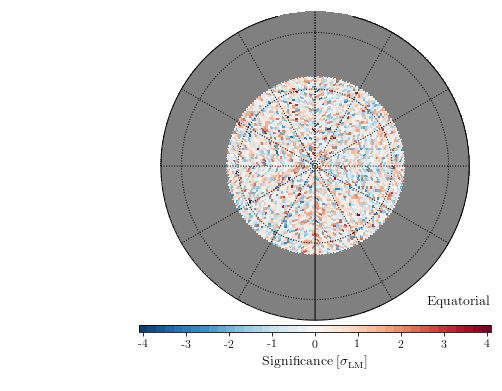

In [17]:
print(sig_light.max())
print(sig_light[sig_light != hp.UNSEEN].min())
title = 'Significance [$\mathrm{\sigma_{LM}}$]'
fig, ax = anisotropy.plot_skymap(sig_light, color_palette='RdBu_r', symmetric=True, llabel=years_str, 
                                 cbar_title=title, cbar_min=-4.1, cbar_max=4.1, polar=True, **kwargs_plot_sig)
outfile = 'IC86-{}_sig_{}_nside-{}_smooth-{:0.1f}_decmax-{}.png'.format(years_str, 'light', n_side, smooth, decmax)
plt.savefig(os.path.join(figures_dir, outfile))

nan
nan


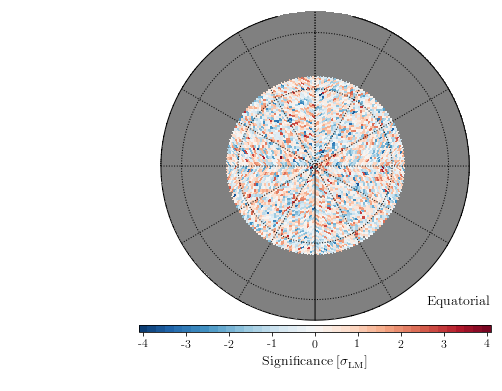

In [18]:
print(sig_heavy.max())
print(sig_heavy[sig_heavy != hp.UNSEEN].min())
title = 'Significance [$\mathrm{\sigma_{LM}}$]'
fig, ax = anisotropy.plot_skymap(sig_heavy, color_palette='RdBu_r', symmetric=True, llabel=years_str, 
                                 cbar_title=title, cbar_min=-4.1, cbar_max=4.1, polar=True, **kwargs_plot_sig)
outfile = 'IC86-{}_sig_{}_nside-{}_smooth-{:0.1f}_decmax-{}.png'.format(years_str, 'heavy', n_side, smooth, decmax)
plt.savefig(os.path.join(figures_dir, outfile))

# Projected relative intensity
[ [back to top](#top) ]

In [37]:
kwargs_relint_proj = dict(kwargs_relint)
kwargs_relint_proj['scale'] = None

Get relative intensity (statistical) error plot

In [38]:
relint_all = anisotropy.get_map(name='relint', composition='all', **kwargs_relint_proj)
relint_all_err = anisotropy.get_map(name='relerr', composition='all', **kwargs_relint_proj)

Get projected relative intensity

In [39]:
# ri_all, ri_all_err, ra, ra_err = anisotropy.get_proj_relint(relint_all, relint_all_err,
#                                                             n_bins=n_bins, decmax=decmax)
data_all = anisotropy.get_map(name='data', composition='all', **kwargs_relint_proj)
ref_err = anisotropy.get_map(name='ref', composition='all', **kwargs_relint_proj)
ri_all, ri_all_err, ra, ra_err = anisotropy.get_binned_relint(data_all, ref_err,
                                                            n_bins=n_bins, decmax=decmax)

In [40]:
n_dof = ri_all.shape[0]

chi2_all = np.sum(ri_all**2 / ri_all_err**2)
chi2_all_red = chi2_all / n_dof
chi2_all

120.40946725296405

In [41]:
from scipy.stats import chi2

In [42]:
p_all = chi2.sf(chi2_all, n_dof, loc=0, scale=1)
s_all = erfcinv(2*p_all)*np.sqrt(2)
print(p_all, s_all)

6.16737834724e-06 4.37158543291


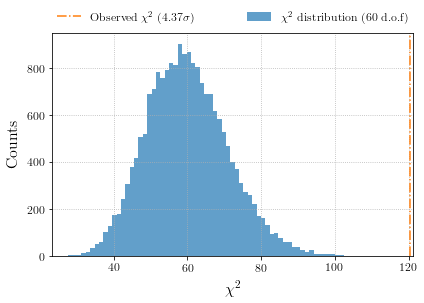

In [43]:
chi2_samples = chi2.rvs(n_dof, loc=0, scale=1, size=int(2e4), random_state=2)
fig, ax = plt.subplots()
counts, bins, _ = ax.hist(chi2_samples, bins=75, alpha=0.7, label='$\mathrm{\chi^2}$ distribution '+'({} d.o.f)'.format(n_dof))
ax.axvline(chi2_all, marker='None', ls='-.', color='C1', lw=1.5, label='Observed $\mathrm{\chi^2}$ ' + '({:0.2f}$\\sigma$)'.format(s_all))
ax.set_ylabel('Counts')
ax.set_xlabel('$\mathrm{\chi^2}$')
ax.grid()
# ax.legend()
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., frameon=False)
outfile = 'chi2-dist_proj-RI-all.png'
plt.savefig(os.path.join(figures_dir, outfile))
plt.show()

In [44]:
chi2.sf(chi2_all, ri_all.shape[0]-1, loc=0, scale=1)

4.2360943450950033e-06

In [45]:
popt_all, perr_all, _ = anisotropy.get_proj_fit_params(np.deg2rad(ra), ri_all, sigmay=ri_all_err, l=3)

amp_all = popt_all[1]
amp_err_all = perr_all[1]

phase_all = np.rad2deg(popt_all[2])
phase_err_all = np.rad2deg(perr_all[2])

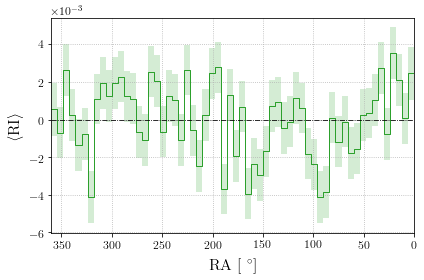

In [46]:
fig, ax = plt.subplots()
# ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', c='C2', label='all')
ra_bins = np.linspace(0, 360, n_bins + 1)
plotting.plot_steps(ra_bins, ri_all, yerr=ri_all_err, color='C2', label='all', fillalpha=0.2, ax=ax)
# ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_all[:3]), color='C2', marker='None')

ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle}$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.grid()
# ax.set_ylim(-1.5e-3, 1.5e-3)
ax.set_xlim(0, 360)
ax.invert_xaxis()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax.legend()

# all_amp_str = 'Amp = {:0.2e} +/- {:0.1e}'.format(amp_all, amp_err_all)
# all_phase_str = 'Phase = {:0.2f} {} +/- {:0.2f} {}'.format(phase_all, '$^{\circ}$', phase_err_all, '$^{\circ}$')
# ax.text(250, 5.0e-3, all_amp_str + '\n' + all_phase_str)

outfile = 'IC86-{}_proj-RI-all.png'.format(years_str)
plt.savefig(os.path.join(figures_dir, outfile))
plt.show()

In [47]:
# relint_light = anisotropy.get_map(name='relint', composition='light', **kwargs_relint_proj)
# relint_light_err = anisotropy.get_map(name='relerr', composition='light', **kwargs_relint_proj)
# ri_light, ri_light_err, ra, ra_err = anisotropy.get_proj_relint(relint_light, relint_light_err,
#                                                                 n_bins=n_bins, decmax=decmax)

In [48]:
data_light = anisotropy.get_map(name='data', composition='light', **kwargs_relint_proj)
ref_light = anisotropy.get_map(name='ref', composition='light', **kwargs_relint_proj)
ri_light, ri_light_err, ra, ra_err = anisotropy.get_binned_relint(data_light, ref_light,
                                                                n_bins=n_bins, decmax=decmax)

In [49]:
# relint_heavy = anisotropy.get_map(name='relint', composition='heavy', **kwargs_relint_proj)
# relint_heavy_err = anisotropy.get_map(name='relerr', composition='heavy', **kwargs_relint_proj)
# ri_heavy, ri_heavy_err, ra, ra_err = anisotropy.get_proj_relint(relint_heavy, relint_heavy_err,
#                                                                 n_bins=n_bins, decmax=decmax)

In [50]:
data_heavy = anisotropy.get_map(name='data', composition='heavy', **kwargs_relint_proj)
ref_heavy = anisotropy.get_map(name='ref', composition='heavy', **kwargs_relint_proj)
ri_heavy, ri_heavy_err, ra, ra_err = anisotropy.get_binned_relint(data_heavy, ref_heavy,
                                                                n_bins=n_bins, decmax=decmax)

In [51]:
chi2_light = np.sum(ri_light**2 / ri_light_err**2)
chi2_heavy = np.sum(ri_heavy**2 / ri_heavy_err**2)
p_light = chi2.sf(chi2_light, n_dof, loc=0, scale=1)
s_light = erfcinv(2*p_light)*np.sqrt(2)
print(p_light, s_light)
p_heavy = chi2.sf(chi2_heavy, n_dof, loc=0, scale=1)
s_heavy = erfcinv(2*p_heavy)*np.sqrt(2)
print(p_heavy, s_heavy)

0.000746732250633 3.17595046568
8.41830471714e-08 5.23125167862


In [52]:
def calc_chi2(ri_0, ri_1, ri_err_0, ri_err_1):
    chi2 = np.sum((ri_0 - ri_1)**2/(ri_err_0**2 + ri_err_1**2)) / ri_0.shape[0]
    return chi2

In [53]:
calc_chi2(ri_light, ri_heavy, ri_light_err, ri_heavy_err)

1.8555762387258667

In [54]:
light_skymap_file = anisotropy.get_skymap_files(config=config, n_side=n_side, composition='light',
                                               low_energy=low_energy)
heavy_skymap_file = anisotropy.get_skymap_files(config=config, n_side=n_side, composition='heavy',
                                               low_energy=low_energy)
chi2_data = ts.get_proj_RI_red_chi2(light_skymap_file, heavy_skymap_file, smooth=smooth, n_bins=n_bins, decmax=decmax)
print(chi2_data)

0.076318511193


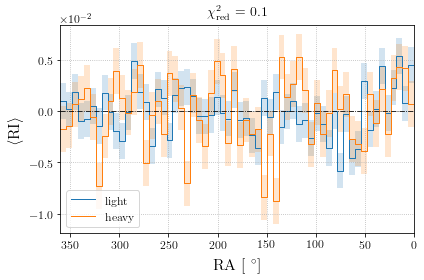

In [55]:
fig, ax = plt.subplots()
plotting.plot_steps(ra_bins, ri_light, yerr=ri_light_err, color='C0', label='light', fillalpha=0.2, ax=ax)
plotting.plot_steps(ra_bins, ri_heavy, yerr=ri_heavy_err, color='C1', label='heavy', fillalpha=0.2, ax=ax)
ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle}$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.set_title('$\mathrm{\chi^2_{red}}$' + ' = {:0.1f}'.format(chi2_data))
ax.legend()
ax.grid()
ax.set_xlim(ra_bins.min(), ra_bins.max())
ax.invert_xaxis()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
outfile = 'IC86-{}_proj-RI-comps.png'.format(years_str)
plt.savefig(os.path.join(figures_dir, outfile))
plt.show()

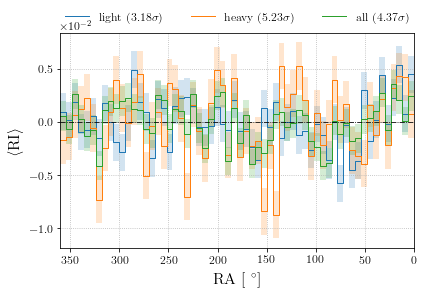

In [56]:
fig, ax = plt.subplots()
plotting.plot_steps(ra_bins, ri_light, yerr=ri_light_err, color='C0',
                    label='light ({:0.2f}$\sigma$)'.format(s_light), fillalpha=0.2, ax=ax)
plotting.plot_steps(ra_bins, ri_heavy, yerr=ri_heavy_err, color='C1',
                    label='heavy ({:0.2f}$\sigma$)'.format(s_heavy), fillalpha=0.2, ax=ax)
plotting.plot_steps(ra_bins, ri_all, yerr=ri_all_err, color='C2', 
                    label='all ({:0.2f}$\sigma$)'.format(s_all), fillalpha=0.2, ax=ax)

ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.grid()
ax.set_xlim(0, 360)
ax.invert_xaxis()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0., frameon=False)

outfile = 'IC86-{}_proj-RI.png'.format(years_str)
plt.savefig(os.path.join(figures_dir, outfile))
plt.show()

# Random trials

In [63]:
df_test_stat = ts.load_test_stats(config=config, low_energy=low_energy, smooth=smooth, n_bins=n_bins, decmax=decmax)
df_test_stat.head()

Loading /data/user/jbourbeau/composition/anisotropy_random_trials/teststat-2011-2012-2013-2014-2015_smooth-7_RAbins-72_decmax--55_lowenergy.hdf...


,proj_RI_red_chi2,sig_ks_dist,sig_pval,sig_cumsum_diff_area
0,0.792411,0.097121,5.303602e-19,11118
1,1.136513,0.038785,2.178079e-03,1418
2,0.925113,0.095043,3.243500e-18,12893
3,0.554181,0.050532,1.868956e-05,8075
4,1.166689,0.028369,5.198488e-02,2336


## Projected relative intensity chi-squared

In [64]:
def get_proj_trial_dict(config, trial_num):
    proj_dict = {}
    proj_dict['trial'] = trial_num
    trial_files_0 = []
    trial_files_1 = []
    for c in config:
        map_dir = os.path.join(comp.paths.comp_data_dir, c + '_data',
                               'anisotropy/random_trials')
        sample_0_file = os.path.join(map_dir, 'random_split_0_trial-{}.fits'.format(trial_num))
        trial_files_0.append(sample_0_file)

        sample_1_file = os.path.join(map_dir, 'random_split_1_trial-{}.fits'.format(trial_num))
        trial_files_1.append(sample_1_file)

        
    relint_0 = anisotropy.get_map(files=trial_files_0, name='relint', **kwargs_relint_proj)
    relint_1 = anisotropy.get_map(files=trial_files_1, name='relint', **kwargs_relint_proj)

    relerr_0 = anisotropy.get_map(files=trial_files_0, name='relerr', **kwargs_relint_proj)
    relerr_1 = anisotropy.get_map(files=trial_files_1, name='relerr', **kwargs_relint_proj)

    ri_0, ri_0_err, ra, _ = anisotropy.get_proj_relint(relint_0, relerr_0, n_bins=n_bins, decmax=decmax)
    ri_1, ri_1_err, ra, _ = anisotropy.get_proj_relint(relint_1, relerr_1, n_bins=n_bins, decmax=decmax)

    proj_dict['ri_0'] = ri_0
    proj_dict['ri_0_err'] = ri_0_err
    proj_dict['ri_1'] = ri_1
    proj_dict['ri_1_err'] = ri_1_err

    proj_dict['chi2'] = ts.get_proj_RI_red_chi2(trial_files_0, trial_files_1, smooth=smooth,
                                                n_bins=n_bins, decmax=decmax)
        
    return proj_dict

In [65]:
n_trials = 16
proj_dicts = [delayed(get_proj_trial_dict)(config, trial_num) for trial_num in range(n_trials)]
proj_df = delayed(pd.DataFrame.from_records)(proj_dicts, index='trial')

In [66]:
with ProgressBar() as bar:
    proj_df = proj_df.compute(get=multiprocessing.get, num_workers=10)

proj_df.head()

[########################################] | 100% Completed | 43.6s


,chi2,ri_0,ri_0_err,ri_1,ri_1_err
trial,,,,,
0,0.792411,"[0.00195935496685, 0.00148192267318, 0.0012030...","[0.00145975157854, 0.00131813170149, 0.0014911...","[0.00214225098479, 0.00201424999383, 0.0016007...","[0.00178442425105, 0.00161862649659, 0.0018346..."
1,1.136513,"[0.00141542630946, 0.00169431576371, 0.0019804...","[0.00145487093335, 0.00131904200537, 0.0014966...","[0.00290491754923, 0.00225163746065, 0.0015010...","[0.00179677455266, 0.00162211560632, 0.0018353..."
2,0.925113,"[0.00350158093997, 0.00384588507846, 0.0037115...","[0.00146250349234, 0.00132600599538, 0.0015022...","[0.00118728134832, 0.000321761245054, 0.000358...","[0.00178694279809, 0.00161472315392, 0.0018325..."
3,0.554181,"[0.0026562414878, 0.00273570564619, 0.00290720...","[0.00146221497195, 0.00132436341466, 0.0015010...","[0.00261244948032, 0.00204905885417, 0.0012216...","[0.00179038398427, 0.00162049453374, 0.0018357..."
4,1.166689,"[0.00117337948436, 0.00121487450893, 0.0010374...","[0.00145769096523, 0.00132097153005, 0.0014964...","[0.00515037776048, 0.0043794196214, 0.00351957...","[0.00179756783109, 0.00162490456515, 0.0018401..."


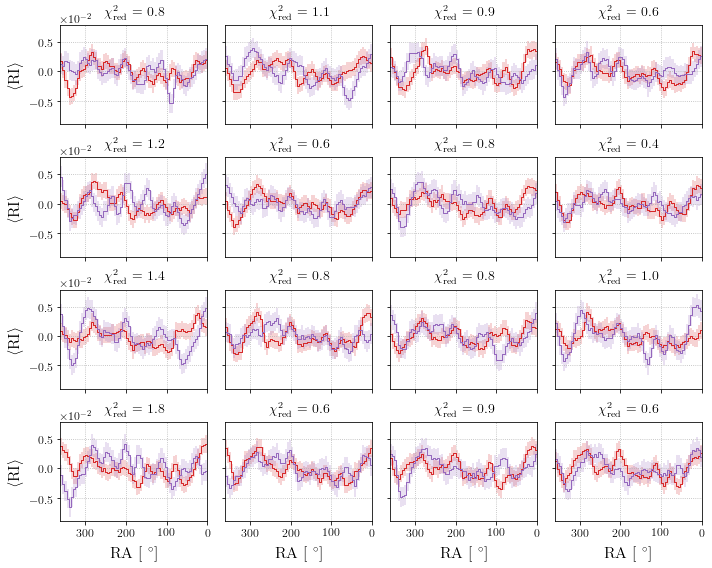

In [67]:
n_side = np.sqrt(n_trials).astype(int)
fig, axarr = plt.subplots(n_side, n_side, figsize=(10, 8), sharex=True, sharey=True)
for trial, ax in zip(proj_df.index, axarr.flatten()):
    
    proj_trial = proj_df.loc[trial]

    ra_bins = np.linspace(0, 360, n_bins + 1)
    ax = plotting.plot_steps(ra_bins, proj_trial['ri_0'], yerr=proj_trial['ri_0_err'], color='C3', ax=ax)
    ax = plotting.plot_steps(ra_bins, proj_trial['ri_1'], yerr=proj_trial['ri_1_err'], color='C4', ax=ax)

    ax.set_title('$\mathrm{\chi^2_{red}}$' + ' = {:0.1f}'.format(proj_trial['chi2']))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_xlim(ra_bins.min(), ra_bins.max())
#     ax.set_ylim(-1e-2, 1e-2)
    ax.invert_xaxis()
    ax.grid()

    for i, row in enumerate(axarr):
        for j, cell in enumerate(row):
            if i == len(axarr) - 1:
                cell.set_xlabel('RA [ $^{\circ}$]')
            if j == 0:
                cell.set_ylabel('$\mathrm{\langle RI \\rangle }$')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'projRI-random-trials-grid.png'))
plt.show()

In [68]:
test_stat = df_test_stat['proj_RI_red_chi2']
pval = np.sum(test_stat > chi2_data)/len(test_stat)
print(pval)
significance = erfcinv(2*pval)*np.sqrt(2)
print(significance)

0.0
inf


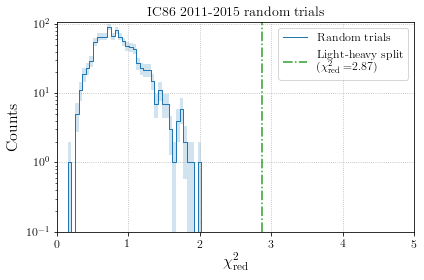

In [69]:
fig, ax = plt.subplots()
# chi2_max = 1.0
chi2_max = 5
chi2_bins = np.linspace(0, chi2_max, 100)
counts = np.histogram(df_test_stat['proj_RI_red_chi2'], bins=chi2_bins)[0]
# ax = plotting.plot_steps(chi2_bins, counts, yerr=np.sqrt(counts))
ax = plotting.plot_steps(chi2_bins, counts, yerr=np.sqrt(counts), label='Random trials')
ax.axvline(chi2_data, marker='None', ls='-.', color='C2', lw=1.5,
           label='Light-heavy split \n ($\mathrm{\chi^2_{red}} = '+'${:0.2f})'.format(chi2_data))
ax.set_xlabel('$\mathrm{\chi^2_{red}}$')
ax.set_ylabel('Counts')
ax.set_title('IC86 {} random trials'.format(years_str))
# ax.text(0.3, 4, 'p-value $= {:g}$'.format(pval) + \
#              '\n significance $= {:0.2f}\sigma$'.format(significance))
ax.set_ylim(1e-1)
ax.set_xlim(0, chi2_max)
ax.set_yscale('log', nonposy='clip')
ax.legend()
ax.grid()
plt.savefig(os.path.join(figures_dir, 'random-trials-chi2_{}.png'.format(years_str)))
plt.show()

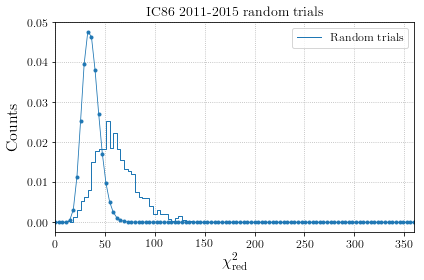

In [70]:
fig, ax = plt.subplots()
# chi2_max = 1.0
chi2_max = 5*n_bins
chi2_bins = np.linspace(0, chi2_max, 100)
counts = np.histogram(df_test_stat['proj_RI_red_chi2']*n_bins, bins=chi2_bins, density=True)[0]
# ax = plotting.plot_steps(chi2_bins, counts, yerr=np.sqrt(counts))
ax = plotting.plot_steps(chi2_bins, counts, label='Random trials')
x = np.linspace(0, 5*n_bins, 100)
ax.plot(x, chi2.pdf(x, df=36))
# ax.axvline(chi2_data, marker='None', ls='-.', color='C2', lw=1.5,
#            label='Light-heavy split \n ($\mathrm{\chi^2_{red}} = '+'${:0.2f})'.format(chi2_data))
ax.set_xlabel('$\mathrm{\chi^2_{red}}$')
ax.set_ylabel('Counts')
ax.set_title('IC86 {} random trials'.format(years_str))
# ax.text(0.3, 4, 'p-value $= {:g}$'.format(pval) + \
#              '\n significance $= {:0.2f}\sigma$'.format(significance))
# ax.set_ylim(1e-1)
ax.set_xlim(0, chi2_max)
# ax.set_yscale('log', nonposy='clip')
ax.legend()
ax.grid()
# plt.savefig(os.path.join(figures_dir, 'random-trials-chi2_{}.png'.format(years_str)))
plt.show()

In [ ]:
chi2.pdf(np.linspace(0, 5, 100), df=36)